## Least-squared regression

### Imports

In [186]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.get_cachedir()
plt.style.use("seaborn-ticks")
from numpy.random import randn
import time
from functools import wraps

### Runtime

In [187]:
def runtime(func):
    @wraps(func)
    def runtime_wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        end_time = time.perf_counter()
        total_time = end_time - start_time
        print("\n", f'Function {func.__name__} took {total_time:.4f} seconds')
        return result
    return runtime_wrapper

### Values

In [188]:
n = 500 # number of points
sigma = 2
sigma2 = 2*sigma**2
lam = 0.000001

# Approximation parameters
m = 20 # number of samples
w = randn(m) / sigma
b = np.random.rand(m)*2*np.pi

# Example functions
x = randn(n)/2
y=np.cos(x) + randn(n) * 1e-1 # randn(n) is noise

x_sort = np.sort(x)

### Gaussian kernel

In [189]:
def k_gauss(x, z): 
    k = np.exp(-((np.linalg.norm(x-z))**2)/(2*sigma**2))
    return k
    
@runtime
def K_gauss(x, y, n):
    Kxy = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            Kxy[i, j] = k_gauss(x[i], y[j])
    return Kxy

#### Alpha

In [190]:
@runtime
def alpha_gauss(x, y, n):
    K = K_gauss(x, x, n)
    # TODO: replace np.linalg.inv with np.linalg.solve
    alpha_gauss = np.linalg.inv(K + n*lam*np.eye(n)) @ y
    return alpha_gauss
    
alpha_ = alpha_gauss(x, y, n)


 Function K_gauss took 4.1585 seconds

 Function alpha_gauss took 4.1804 seconds


#### Estimated function

In [191]:
@runtime
def function_gauss(x, n, alpha):
    x_sort = np.sort(x)
    f = np.zeros(n)
    for i in range(n):
        sum = 0
        for j in range(n):
            sum = sum + alpha[j] * k_gauss(x_sort[i], x[j])
        f[i] = sum
    return f

func = function_gauss(x, n, alpha_)


 Function function_gauss took 4.1467 seconds


#### Plot

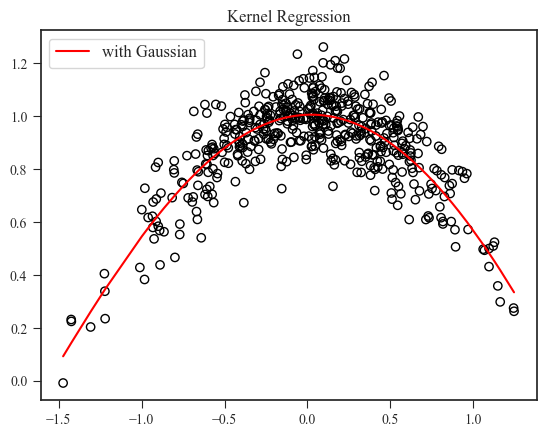

In [192]:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.serif": "Times New Roman",
})
#plt.rc('text', usetex=False)
plt.scatter(x,y, facecolors ='none' , edgecolors = "k" , marker = "o")
plt.plot(x_sort, func, c="r", label="with Gaussian")
plt.title("Kernel Regression")
plt.legend( loc = "upper left" , frameon = True , prop ={'size': 12 } )
plt.show()

## Random Fourier Features

### Approximation 1

In [193]:
# Feature vector
def psi(x, w, b):
    return np.sqrt(2)*np.cos(w*x + b)

def k_approx1(x_i, z_i, w, b):
    return 1/m * np.sum(psi(x_i, w, b) * psi(z_i, w, b))

# Not in use
def K_approx1(x, z, w, b, m):
    K = np.zeros((n ,m))
    for i in range(n):
        for j in range(m):
            K[i, j] = k_approx1(x[i], z[j], w[j], b[j])
    return K

K_ = K_approx1(x, x, w, b, m)

#### Alpha

In [194]:
def alpha_approx1(x, y, lam, w, b, m):
    Psi = np.zeros((m, n))
    for i in range(n):
        Psi[:, i] = psi(x[i], w, b)
    return np.linalg.inv(Psi @ Psi.T + m*lam*np.eye(m)) @ Psi @ y

# Same as
def alpha_approx11(x, y, lam, w, b, m):
    K = np.zeros((n,m))
    for i in range(n):
        for j in range(m):
            K[i, j] = psi(x[i], w[j], b[j])
    return np.linalg.inv(K.T @ K + lam*np.eye(m)) @ K.T @ y

alpha_approx = alpha_approx1(x, y, lam, w, b, m)
alpha_approx1_ = alpha_approx11(x, y, lam, w, b, m)

print(alpha_approx.shape)
print(alpha_approx1_.shape)

(20,)
(20,)


#### Estimated function

In [195]:
def function_approx1(x, n, alpha):
    x_sort = np.sort(x)
    f = np.zeros(n)
    for i in range(n):
        f[i] = np.sum(alpha*psi(x_sort[i], w, b))
    return f

func_approx1 = function_approx1(x, n, alpha_approx)

#### Plot

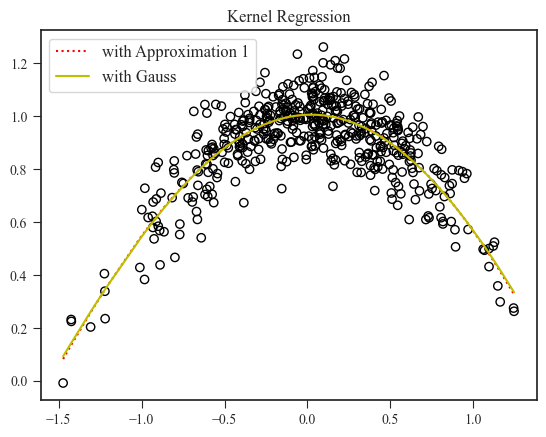

In [196]:
plt.scatter(x,y, facecolors ='none' , edgecolors = "k" , marker = "o")
plt.plot(x_sort, func_approx1, c="r", label="with Approximation 1", ls = ":")
plt.plot(x_sort, func, c="y", label="with Gauss")
plt.title("Kernel Regression")
plt.legend( loc = "upper left" , frameon = True , prop ={'size': 12 } )
plt.show()

### Approximation 2

In [197]:
def psi_cos(x, w):
    return np.cos(w*x)

def psi_sin(x, w):
    return np.sin(w*x)

def k_approx2(x, y, w, m):
    return np.sum(1/np.sqrt(m) * psi_cos(x, w, m)*psi_cos(y, w, m)) + 1/np.sqrt(m)*np.sum(psi_cos(x, w, m)*psi_cos(y, w, m))

# Not in use
def K_approx2(x, y, w, n, m):
    K = np.zeros((n, m))
    for i in range(n):
        for j in range(m): 
            K[i, j] = k_approx2(x, y, w, m)
    return K

### Alpha

In [198]:
@runtime
def alpha_approx2(x, y, w, n, m):
    Psi = np.zeros((m, n))
    for i in range(n):
        Psi[:, i] = psi_cos(x[i], w) + psi_sin(x[i], w)
    alpha = np.linalg.inv(Psi @ Psi.T + m*lam*np.eye(m)) @ Psi @ y
    return alpha

alpha_2 = alpha_approx2(x, y, w, n, m)


 Function alpha_approx2 took 0.0073 seconds


#### Estimated function

In [199]:
@runtime
def function_approx2(x, n, alpha):
    x_sort = np.sort(x)
    f = np.zeros(n)
    for i in range(n):
        f[i] = np.sum(alpha*(psi_cos(x_sort[i], w) + psi_sin(x_sort[i], w)))
    return f

func_approx2 = function_approx2(x, n, alpha_2)


 Function function_approx2 took 0.0122 seconds


#### Plot

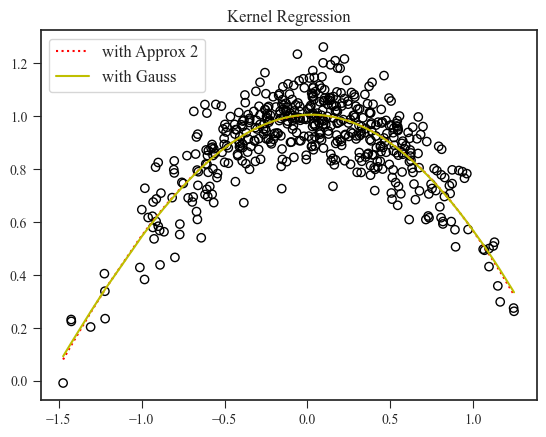

In [200]:
plt.scatter(x,y, facecolors ='none' , edgecolors = "k" , marker = "o")
plt.plot(x_sort, func_approx2, c="r", label="with Approx 2", ls = ":")
plt.plot(x_sort, func, c="y", label="with Gauss")
plt.title("Kernel Regression")
plt.legend( loc = "upper left" , frameon = True , prop ={'size': 12 } )
plt.show()

## All plots

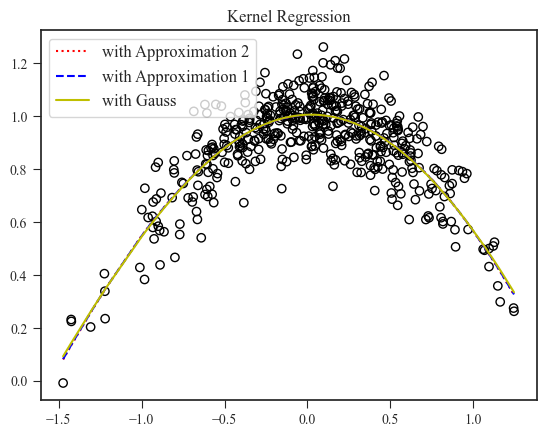

In [201]:
plt.scatter(x,y, facecolors ='none' , edgecolors = "k" , marker = "o")
plt.plot(x_sort, func_approx2, c="r", label="with Approximation 2", ls = ":")
plt.plot(x_sort, func_approx1, c="b", label="with Approximation 1", ls = "--")
plt.plot(x_sort, func, c="y", label="with Gauss")
plt.title("Kernel Regression")
plt.legend( loc = "upper left" , frameon = True , prop ={'size': 12 } )
plt.show()

### Error

In [202]:
def error(f_gauss, f_approx): 
    sum = 0
    for i in range(len(f_gauss)):
        sum += f_gauss[i] - f_approx[i]
    return sum

error_1 = error(func, func_approx1)
error_2 = error(func, func_approx2)

print(error_1)
print(error_2)

0.0009946225390535662
0.0009965269465355836


## Box plot


 Function alpha_approx2 took 0.0050 seconds

 Function function_approx2 took 0.0095 seconds

 Function alpha_approx2 took 0.0050 seconds

 Function function_approx2 took 0.0117 seconds

 Function alpha_approx2 took 0.0061 seconds

 Function function_approx2 took 0.0087 seconds

 Function alpha_approx2 took 0.0200 seconds

 Function function_approx2 took 0.0118 seconds


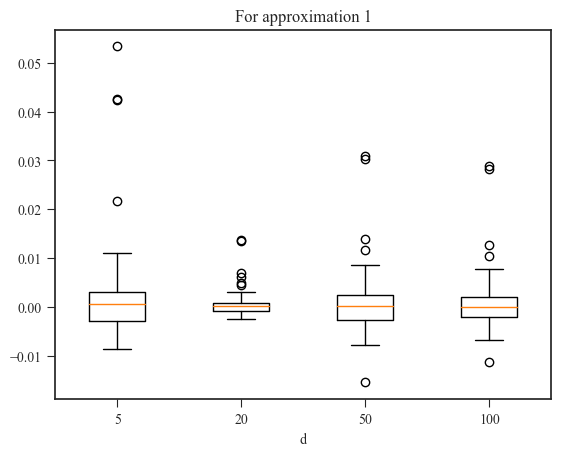

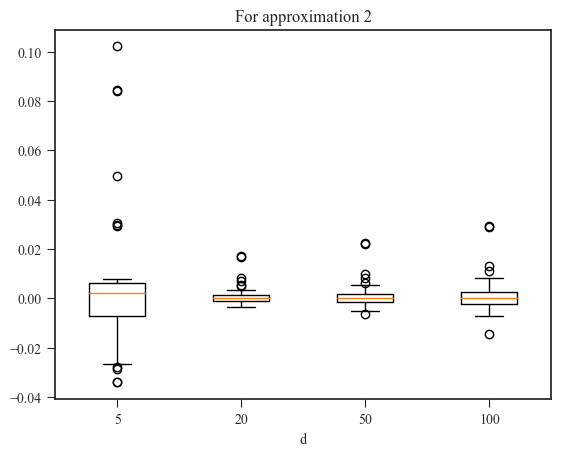

In [203]:
different_m = [5, 20, 50, 200]
u = np.zeros((n, len(different_m)))
v = np.zeros((n, len(different_m)))
#sum = np.zeros((2, len(different_m)))
for i in range(len(different_m)):
    m = different_m[i]
    w = randn(m) / sigma
    b = np.random.rand(m)*2*np.pi
    alpha_app1 = alpha_approx1(x, y, lam, w, b, m)
    func_1 = function_approx1(x, n, alpha_app1)
    alpha_app2 = alpha_approx2(x, y, w, n, m)
    func_2 = function_approx2(x, n, alpha_app2)
    for j in range(len(func)):
        #sum[0, i] += func[j] - func_1[j]
        #sum[1, i] += func[j] - func_2[j]
        u[j, i] += func[j] - func_1[j]
        v[j, i] += func[j] - func_2[j]

#print(sum) 

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.title("For approximation 1")
ax.boxplot([u[:, 0], u[:, 1], u[:, 2], u[:, 3]], labels = [5, 20, 50, 100])
ax.set_xlabel('d')
#ax.set_ylim(-0.1, 0.1)
plt.show()    

# Approximation 2
fig2 = plt.figure()
ax2 = fig2.add_subplot(1, 1, 1)
plt.title("For approximation 2")
ax2.boxplot([v[:, 0], v[:, 1], v[:, 2], v[:, 3]], labels = [5, 20, 50, 100])
ax2.set_xlabel('d')
#ax2.set_ylim(-0.1, 0.1)
plt.show()   